# Word2Vec (Skipgram )

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [14]:
from nltk.corpus import brown
brown.categories()
news_corpus = brown.sents(categories=['news'])
  

In [15]:
news_corpus[1]

['The',
 'jury',
 'further',
 'said',
 'in',
 'term-end',
 'presentments',
 'that',
 'the',
 'City',
 'Executive',
 'Committee',
 ',',
 'which',
 'had',
 'over-all',
 'charge',
 'of',
 'the',
 'election',
 ',',
 '``',
 'deserves',
 'the',
 'praise',
 'and',
 'thanks',
 'of',
 'the',
 'City',
 'of',
 'Atlanta',
 "''",
 'for',
 'the',
 'manner',
 'in',
 'which',
 'the',
 'election',
 'was',
 'conducted',
 '.']

In [16]:
np.__version__, torch.__version__

('1.26.4', '2.4.1')

In [17]:
import matplotlib
matplotlib.__version__

'3.9.1.post1'

## 1. Load data

In [18]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
          "dog cat animal", "cat animal dog", "cat dog animal"]

In [19]:
#1. tokenization
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [20]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(news_corpus))) #all the words we have in the system - <UNK>

In [21]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['dog']

10666

In [22]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

In [23]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'indicates'

## 2. Prepare train data

In [24]:
#create pairs of center word, and outside word

def random_batch(batch_size, news_corpus,windows_size=2):

    skipgrams = []

    #loop each corpus
    for doc in news_corpus:
        #look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words = 2 words
            if windows_size==2:
                outside = (word2index[doc[i-1]], word2index[doc[i+1]])
                #for each of these two outside words, we gonna append to a list
                for each_out in outside:
                    skipgrams.append([center, each_out])
                    #center, outside1;   center, outside2
            else:
                outside = []
                for j in range(windows_size):
                    if i-j-1 >= 0:
                        outside.append(word2index[doc[i-j-1]])
                    if i+j+1 < len(doc):
                        outside.append(word2index[doc[i+j+1]]) 
                #for each of these two outside words, we gonna append to a list
                for _,each_out in enumerate(outside):
                    skipgrams.append([center, each_out])
                    #center, outside1;   center, outside2

                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
            
x, y = random_batch(2, news_corpus,3)

In [25]:
x.shape  #batch_size, 1

(2, 1)

In [26]:
x

array([[2970],
       [5605]])

In [27]:
y.shape  #batch_size 1

(2, 1)

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [28]:
len(vocabs)

14395

In [29]:
embedding = nn.Embedding(7, 2)

In [30]:
# x_tensor = torch.LongTensor(x)
# embedding(x_tensor).shape  #(batch_size, 1, emb_size)

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

In [31]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1) 

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size) 
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
        return loss
        

In [32]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[    0,     1,     2,  ..., 14392, 14393,     6],
        [    0,     1,     2,  ..., 14392, 14393,     6]])

In [33]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(14395, 2)
  (embedding_outside): Embedding(14395, 2)
)

In [34]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [35]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [36]:
loss

tensor(9.2030, grad_fn=<NegBackward0>)

## 4. Training

In [37]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [38]:
num_epochs = 100

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, news_corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch     10 | Loss: 12.202589
Epoch     20 | Loss: 9.499475
Epoch     30 | Loss: 10.421511
Epoch     40 | Loss: 9.534157
Epoch     50 | Loss: 10.595751
Epoch     60 | Loss: 10.000448
Epoch     70 | Loss: 11.337334
Epoch     80 | Loss: 8.910772
Epoch     90 | Loss: 9.785046
Epoch    100 | Loss: 9.996054


## 5. Plot the embeddings

Is fruit really near to banana?
Is fruit really far from cat?

In [39]:
vocabs

['streetcar',
 'Gin',
 'prominently',
 "yesterday's",
 'tourists',
 'indicates',
 'denomination',
 'i.e.',
 'Decathlon',
 'address',
 'honorary',
 'private-school',
 '242%',
 'testing',
 'disappointing',
 'fondness',
 'dissents',
 'long',
 '2100',
 'duress',
 'Practice',
 'stereotype',
 "Flock's",
 'bedroom',
 '25%',
 'Person',
 'chatting',
 'Surrounding',
 'speck',
 'equipped',
 '6-foot-10',
 'Madame',
 'Bow',
 'composition',
 'afraid',
 'Wilderness',
 'marketings',
 'glanced',
 'nymphomaniacs',
 'clothing',
 'primary',
 'Eaton',
 'internationalist',
 'specified',
 'begging',
 'somewhat',
 'thing',
 'linen',
 'Gee',
 'agenda',
 'purchased',
 'harm',
 'Allegretti',
 'lamp',
 'discovering',
 'inappropriate',
 'shifting',
 'wheat',
 'inroads',
 'frequently',
 'others',
 "year's",
 'Benjamin',
 'evaluating',
 'receives',
 'children',
 'Song',
 'Dallas-headquartered',
 'de',
 'latter',
 'standard',
 'daughter',
 'hat',
 'Through',
 'conspired',
 'ending',
 'saw',
 'reviewed',
 'cautious',


In [40]:
banana = torch.LongTensor([word2index['roll']])
# banana = torch.LongTensor([word2index['banana']])
banana

tensor([5312])

In [41]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[-0.1426, -0.6612]], grad_fn=<DivBackward0>)

In [42]:
banana_embed_o

tensor([[ 1.3215, -0.9669]], grad_fn=<EmbeddingBackward0>)

In [43]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [44]:
# get_embed('fruit')
get_embed('crabs')

(-0.07588478177785873, -0.4038788676261902)

In [45]:
get_embed('cat')

KeyError: 'cat'

In [ ]:
get_embed('dog')

In [ ]:
get_embed('banana')

KeyboardInterrupt: 

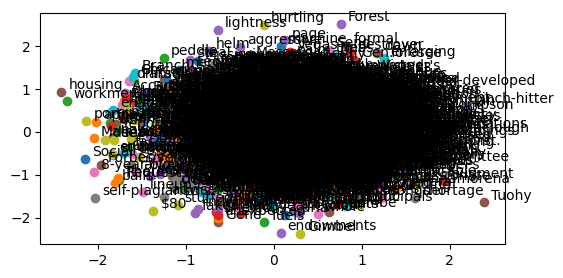

In [58]:
# plt.figure(figsize=(6, 3))
# for i, word in enumerate(vocabs):
#     x, y = get_embed(word)
#     plt.scatter(x, y)
#     plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
# plt.show()

## 6. Cosine similarity

In [ ]:
banana = get_embed('banana')
banana

In [ ]:
fruit = get_embed('fruit')
fruit

In [ ]:
unk = get_embed('<UNK>')
unk

In [ ]:
np.array(banana) @ np.array(unk)

In [ ]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(unk)))
print(cosine_similarity(np.array(banana), np.array(fruit)))